# Capstone 2. Data cleaning & storytelling

May 17, 2018
***
Data source: [kaggle dataset](https://www.kaggle.com/PromptCloudHQ/us-jobs-on-monstercom)

**Objective:** As I mentioned in the proposal, the major goal of this capstone project is to help job seekers, especially those new graduates with not previous job experience, find their dream job based on their answers to our questionnaire. 

Questionnaire will cover those aspects:
- Industry 
- Location
- Culture

Each aspect need give a number indicating the level of the importance.

And finally, we will do a matching between job descriptions and the answer of the questionnaire.
***
*For example: *

I may answer the questionnaire in this way:

- Industry = art; artificial intelligence. Weight = 40%
- Location = big cities; eastern coast. Weight = 20%
- Culture = innovation; big company. Weight = 40%

And I hope to get job recommendations from this project.

In [1]:
# Let's get started:

%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Section 1: Look at the dataset and drop some columns

In [2]:
# import the dataset and see how it looks like
df = pd.read_csv('monster_com-job_sample 2.csv')

# some basic inforamtion
print('There are {:d} job decriptions in the dataset.'.format(df.shape[0]))
print('The jobs are located in those country: ', df.country_code.unique().item())
print('{:d} out of 22000 job descriptions are tagged with a salary'.format(22000-sum(df.salary.isnull())))


There are 22000 job decriptions in the dataset.
The jobs are located in those country:  US
3446 out of 22000 job descriptions are tagged with a salary


In [3]:
# drop columns that are not helpful for the following analysis
df = df.drop(df.columns[[0,1,2,3,4,7,10,11,12,13]],axis=1)
df.head()

,job_description,job_title,location,organization
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail


In this dataset, we kept those columns which would be useful in the following sections. 
 - The **job_description** and **job_title** will be used to match industry. 
 - **organization** will be used for finding the name of that company and the culture of it. 
 - **location**, will be used to calculate distance, as well as finding out if the job located at big or small city, with increasing or declining population and so on.

# Section 2: Location 

## Step 1: extract the location information: zip code, state, city


In [4]:
# extract zip code information from the location column
# extract state information from the location column
p = re.compile(r'(?<![A-Z])[A-Z]{2}(?![A-Z])')
for i, row in df.iterrows():
    # add the column zip code
    ls = []
    for char in row.location:
        if char.isdigit():
            ls.append(char)
    if len(ls) == 5:
        df.set_value(i,'zip_code', ''.join(ls))
    
    # add the column state
    str_location = row.location
   
    if len(str_location) < 100 and len(str_location) > 1:
        state = p.search(str_location)
        if state is not None:
            df.set_value(i, 'state', state.group())
            ls = str_location.split(',')
            df.set_value(i, 'city', ls[0])
df.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,NaN,NaN,NaN
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries,NaN,CA,Dixon
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail,NaN,PA,Camphill


### Dataset exploration 1: look at locations that have the biggest number of jobs

In [9]:
df_dropna = df[~df.state.isnull()]

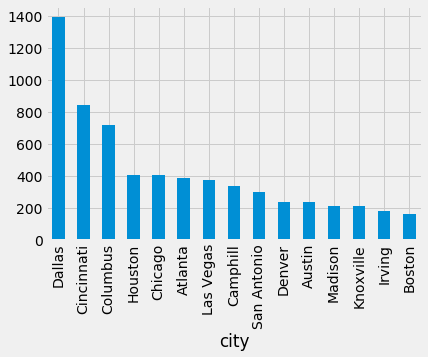

In [43]:
data = df_dropna.groupby('city').count().job_description.sort_values(ascending = False)[:15]
data.plot(kind = 'bar')

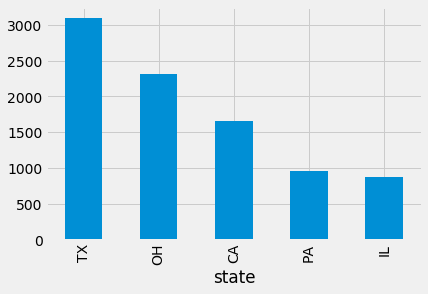

In [41]:
data = df_dropna.groupby('state').count().job_description.sort_values(ascending = False)[:5]
data.plot(kind = 'bar')

### Dataset exploration 2: save the DataFrame as excel and mapping the data in the USA map.

In [48]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('monster_zipcode.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/bin/sh: -c: line 0: syntax error near unexpected token `map.png'
/bin/sh: -c: line 0: `[map](map.png)'


![map](map.png)

## Step 2: determine the location index.
Location index is determined by the distance from where the job is and where the job seeker currently located. The index is also determined by the quality of the location. People may care different things about the location, such as the population, safety, near big city, near national park, city or country, art, education and so on. We can put all those factors in the questionnaire. This location index can be very complex and it would be impossible to complete in a short time. We'll simplify the calculation by picking 1 or 2 factors, like population and safety.


# Section 3: Culture

In this section, we're trying to judge the culture of a company by the size of the company as well as some key adjectives in the job descriptions, such as "flexible", "motivated", "innovative" and so on.


## Step 1: extract company information
We want to extract company information, which means we get the name of the company, and we can find out more about the company by google it. When we want to know about a company, we look at several things, like the size of the company, the history of the company, the review of the company as well as if I have networks in there. The same as the previous location section, it can be a big task to complete all the factors we can think of. But I will pick up a few for practice, such as the size of the company.

In this dataset, it's a little challenging to get the company name because the company name is not clearly marked in the dataset.

The company name is usually associated with key words like "seek", "join". But still, this not always the case. And from the first job description, the word "seeking" was misspelled as "seeing". 

In [55]:
# Let's look at an example: 
df.job_description[1]

'The Wisconsin State Journal is seeking a flexible and motivated reporter/editor to lead its three-person business desk. We’re looking for an experienced journalist able to spot trends, be a watchdog and reflect the Madison area’s vibrant entrepreneurial community. This is a hybrid reporting and editing position that calls for a fleet-footed, multimedia storyteller able to maximize the newspaper’s online presentation while also editing two sections a week. Candidates must have strong news judgment, be well versed in business news and trends and be able to quickly prioritize coverage.At least five years’ experience reporting or editing for digital and print platforms desired. To be considered for the position, applicants must apply online.\xa0As part of your online application, please attach five samples of your work or links to five recent stories.Wisconsin State Journal, 1901 Fish Hatchery Road, Madison, WI 53713Affirmative Action/Equal Opportunity Employer/Pre-employment drug testing

From the above example:

The company we may want extract is "The Wisconsin State Journal". "to lead its three-person business desk", even I have no idea what does that mean. This maybe confusion that "three people" sounds like a startup company, but actually not.

After extracting the company information, we would like to link with another dataset that includes the information of major companies. 

## Step 2: extract the adjectives from the job description.

# Section 4: Industry

In this section, we're trying to get the industry information of the company. Industry such as sports, media, software, communication, devices, music, non-profit and so on. This information may found from those nouns of the job description. For example, from the job description example of Section 3, we may find "Journal", "reporter", "editor", "journalist", "trends" and so on may be a good represent of the industry of the company.